In [10]:
"""
This is the version of compute frequency error, PSNR, SSIM, trace/F, and loss of different other_optimizers
by Chaoyan Nov. 26th, 2025
*Uncomment if running on colab*
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab
"""
#!git clone https://github.com/DmitryUlyanov/deep-image-prior
#!mv deep-image-prior/* ./

'\nThis is the version of compute frequency error, PSNR, SSIM, trace/F, and loss of different other_optimizers\nby Chaoyan Nov. 26th, 2025 \n*Uncomment if running on colab*\nSet Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab\n'

# Import libs

In [11]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2,3,5,6'

from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from models import *

import random
import torch
import torch.optim
import torch.nn as nn
import torch.distributed as dist

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

from utils.denoising_utils import *



torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.
torch.manual_seed(2025) # Fixed random seed for reproducibility

In [12]:
# deJPEG
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'

# Load image

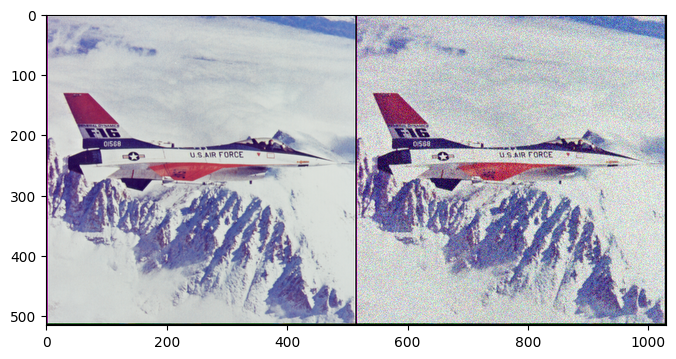

In [13]:
if fname == 'data/denoising/snail.jpg':
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)

    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np

    if PLOT:
        plot_image_grid([img_np], 4, 5);

elif fname == 'data/denoising/F16_GT.png':
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)

    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);
else:
    assert False

# Setup

In [14]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=

LR = 0.02 # ADAM

show_every = 1
exp_weight=0.99

if fname == 'data/denoising/snail.jpg':
    num_iter = 2400
    input_depth = 3
    figsize = 5

    net = skip(
                input_depth, 3,
                num_channels_down = [8, 16, 32, 64, 128],
                num_channels_up   = [8, 16, 32, 64, 128],
                num_channels_skip = [0, 0, 0, 4, 4],
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

elif fname == 'data/denoising/F16_GT.png':
    num_iter = 1000
    input_depth = 32
    figsize = 4


    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128,
                  skip_n33u=128,
                  skip_n11=4,
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    assert False

net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()
# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]);
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

RuntimeError: No CUDA GPUs are available

In [ ]:
# from transformers import Adafactor
def optimize(optimizer_type, parameters, closure, LR, num_iter):
    if optimizer_type == 'LBFGS':
        print('Starting optimization with LBFGS')
        def closure2():
            optimizer.zero_grad()
            return closure()
        optimizer = torch.optim.LBFGS(parameters, max_iter=num_iter, lr=LR, tolerance_grad=-1, tolerance_change=-1)
        optimizer.step(closure2)

    else:
        opt_class = {
            'adam': torch.optim.Adam,
            'SGD': torch.optim.SGD,
            'RMSprop': torch.optim.RMSprop,
            'AdamW': torch.optim.AdamW,
            'RAdam': torch.optim.RAdam,
            # 'Adafactor': Adafactor #torch.optim.Adafactor
            'ASGD': torch.optim.ASGD
        }[optimizer_type]
        optimizer = opt_class(parameters, lr=LR)
        print(f'Starting optimization with {optimizer_type.upper()}')
        for j in range(num_iter):
            optimizer.zero_grad()
            loss = closure()
            optimizer.step()

In [ ]:
# index measurements

from unittest import result


def l1_l2_ratio_model(model):
    '''
    Param Bias=|\theta|1/|\theta|_2
    大 L1/L2 比值 → 参数更“分散”，偏向稀疏解
    小 L1/L2 → 参数接近均匀分布，偏向小范数解
    '''
    all_params = torch.cat([p.detach().view(-1) for p in model.parameters()])
    l1 = torch.sum(all_params.abs())
    l2 = torch.norm(all_params, p=2)
    return (l1 / (l2 + 1e-12)).item()



def frequency_bias(x):
    """
    Compute Freq Bias=log(1+∣F(fθ​(x))∣), return a scalar float.
    卷积结构天然偏向低频 → log(1+|Fx|) 高，反映网络先拟合平滑部分
    """
    # FFT: shape [B, C, H, W], complex
    Xf = torch.fft.fft2(x, norm='ortho')

    # magnitude
    Xf_mag = torch.abs(Xf)

    # log(1 + |F(x)|)
    log_fx = torch.log1p(Xf_mag)

    # return single scalar (mean over all entries)
    return log_fx.mean().item()

def frequency_bias_diff(x1,x2):
    Xf1 = torch.fft.fft2(x1, norm='ortho')
    Xf2 = torch.fft.fft2(x2, norm='ortho')
    Xf_mag1 = torch.abs(Xf1)
    Xf_mag2 = torch.abs(Xf2)
    log_fx1 = torch.log1p(Xf_mag1)
    log_fx2 = torch.log1p(Xf_mag2)
    diff = log_fx1 - log_fx2
    num_up = torch.norm(diff, p=2).item()
    num_down = np.minimum(torch.norm(log_fx1, p=2).item(),torch.norm(log_fx2, p=2).item())
    result = num_up / num_down
    return result

def frequency_bias_diff_wolog(x1,x2):
    Xf1 = torch.fft.fft2(x1, norm='ortho')
    Xf2 = torch.fft.fft2(x2, norm='ortho')
    Xf_mag1 = torch.abs(Xf1)
    Xf_mag2 = torch.abs(Xf2)
    log_fx1 = Xf_mag1 #torch.log1p(Xf_mag1)
    log_fx2 = Xf_mag2 #torch.log1p(Xf_mag2)
    diff = log_fx1 - log_fx2
    num_up = torch.norm(diff, p=2).item()
    num_down = np.minimum(torch.norm(log_fx1, p=2).item(),torch.norm(log_fx2, p=2).item())
    result = num_up / num_down
    return result

def sensitivity_bias(model, x, num_samples=1):
    """
    Sensitivity / Random Trace/ Random Trace / Jacobian Norm
    Tr(J_x J_X^T)
    E[ || J(x)^T ξ ||^2 ], where ξ ~ N(0, I), same shape as model(x)
    函数输出对输入扰动的敏感程度
    大值 → 输出容易随输入变化 → 函数不平滑
    小值 → 输出平滑，对小扰动不敏感 → 强隐式正则, 说明网络天然正则化
    """
    sensitivity = 0.0
    x = x.clone().detach().requires_grad_(True)
    y = model(x)

    for _ in range(num_samples):
        # ξ MUST have same shape as y
        xi = torch.randn_like(y)
        # compute J^T xi wrt input x
        Jv = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=xi,
            retain_graph=True,
            create_graph=False,
        )[0]
        sensitivity += (Jv.pow(2).sum()).item()

    return sensitivity / num_samples

def jacobian_fro_norm(model, x, max_outputs=256):
    """
    Compute the Frobenius norm of the Jacobian J_x f(x):
        ||J||_F^2 = sum_{i,j} (∂y_i / ∂x_j)^2

    model: neural network f
    x: input tensor with requires_grad=True
    max_outputs: we limit how many output dimensions to avoid explosion
    """

    # Clone input with grad
    x = x.clone().detach().requires_grad_(True)
    y = model(x)
    y_flat = y.view(-1)  # flatten output

    # To reduce computation cost, use only first k outputs
    K = min(max_outputs, y_flat.shape[0])
    fro_sq = 0.0

    for i in range(K):
        grad_i = torch.autograd.grad(
            y_flat[i], x,
            retain_graph=True,
            create_graph=False
        )[0]  # same shape as x

        fro_sq += grad_i.pow(2).sum().item()

    return fro_sq


def jacobian_metrics(model, x, num_trace_samples=1, max_fro_outputs=256):
    """
    Compute both:
        1. Sensitivity Bias (Hutchinson Trace Estimation)
            Tr(JJ^T) ≈ E[ || J^T ξ ||^2 ]
        2. Jacobian Frobenius Norm (partial)
            ||J||_F^2 = sum_{i,j} (∂y_i/∂x_j)^2

    Args:
        model: neural network
        x: input tensor
        num_trace_samples: number of Hutchinson samples
        max_fro_outputs: limit # of outputs to compute Frobenius norm

    Returns:
        sensitivity_trace: float
        frobenius_norm: float
    """

    # Prepare input
    x = x.clone().detach().requires_grad_(True)
    y = model(x)
    y_flat = y.view(-1)

    # ----- 1) Sensitivity (Hutchinson Trace) -----
    sensitivity_trace = 0.0
    for _ in range(num_trace_samples):
        xi = torch.randn_like(y)  # same shape as output
        Jv = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=xi,
            retain_graph=True,
            create_graph=False,
        )[0]
        sensitivity_trace += Jv.pow(2).sum().item()
    sensitivity_trace /= num_trace_samples

    # ----- 2) Frobenius Norm (partial) -----
    fro_sq = 0.0
    K = min(max_fro_outputs, y_flat.shape[0])
    for i in range(K):
        grad_i = torch.autograd.grad(
            outputs=y_flat[i],
            inputs=x,
            retain_graph=True,
            create_graph=False,
        )[0]
        fro_sq += grad_i.pow(2).sum().item()

    return sensitivity_trace, fro_sq

def frobenius_unbiased(model, x, K=1024):
    """
    Unbiased estimator of ||J||_F^2 by random output sampling.

    Args:
        model: neural network
        x: input tensor
        K: number of randomly sampled outputs

    Returns:
        fro_est: unbiased Frobenius squared norm
    """
    x = x.clone().detach().requires_grad_(True)
    y = model(x)
    y_flat = y.view(-1)
    M = y_flat.shape[0]  # total num outputs

    # sample random output indices
    idx = torch.randint(0, M, (K,), device=x.device)

    fro_sum = 0.0
    for i in idx:
        grad_i = torch.autograd.grad(
            outputs=y_flat[i],
            inputs=x,
            retain_graph=True,
            create_graph=False,
        )[0]
        fro_sum += grad_i.pow(2).sum().item()

    # unbiased estimator
    fro_est = fro_sum * (M / K)
    return fro_est
def frobenius_hutchinson(model, x, num_samples=1):
    x = x.clone().detach().requires_grad_(True)
    y = model(x)

    fro = 0.0
    for _ in range(num_samples):
        xi = torch.randn_like(y)
        Jv = torch.autograd.grad(
            outputs=y,
            inputs=x,
            grad_outputs=xi,
            retain_graph=True,
            create_graph=False,
        )[0]
        fro += Jv.pow(2).sum().item()

    return fro / num_samples
def jacobian_metrics_unbias(model, x, num_trace_samples=1, K=1024):
    """
    Computes:
        1. Sensitivity (Hutchinson)     = Tr(JJ^T)
        2. Unbiased Frobenius estimate  = ||J||_F^2

    These two should be close.
    """

    # Sensitivity = Frobenius (exact)
    sensitivity = frobenius_hutchinson(model, x, num_trace_samples)

    # Unbiased partial Frobenius
    fro_unbiased = frobenius_unbiased(model, x, K)

    # Their ratio should be around 1 (0.8~1.2)
    return sensitivity, fro_unbiased #, sensitivity / fro_unbiased


def ntk_spectrum(model, x, n_eig=20):
    """
    Compute top NTK eigenvalues using Jacobian-vector product.
    x: input batch (B,C,H,W)
    大的最大特征值 → 网络对输入变化敏感（容易拟合高频）
    小的最大特征值 → 网络较平滑（偏向低频映射）
    """
    model.eval()
    x = x.requires_grad_(True)
    y = model(x)                     # (B, C, H, W)
    B = y.shape[0]
    # Flatten output per sample
    y = y.view(B, -1)
    # Compute Jv for random v
    eigvals = []
    for _ in range(n_eig):
        v = torch.randn_like(y)
        Jv = torch.autograd.grad(
            outputs=y,
            inputs=list(model.parameters()),
            grad_outputs=v,
            retain_graph=True,
            create_graph=False,
            allow_unused=True
        )

        # Convert (list of tensors) → one big vector
        Jv_flat = torch.cat([g.reshape(-1) for g in Jv if g is not None])

        eigvals.append(Jv_flat.pow(2).sum().item())

    return {"NTK_eigenvalues": sorted(eigvals, reverse=True)}

def measure_biases(model, x, img_out):
    return {
        "param_bias": param_bias(model),
        "ntk": ntk_spectrum(model, x),
        "frequency_bias": frequency_bias(img_out),
        "sensitivity": sensitivity_bias(model, x)
    }
FREQ_PARAM = 1000        # every step
FREQ_FREQ_BIAS = 1000    # every 5 steps
FREQ_SENS = 1000        # every 20 steps
FREQ_NTK = 1000        # every 100 steps

# Optimize

In [ ]:
import torch
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import numpy as np
import copy

# Define the list of optimizers to run
OPTIMIZER_LIST = ['SGD', 'LBFGS', 'adam', 'ASGD', 'AdamW', 'RAdam'] #['SGD', 'LBFGS', 'adam']#

# Define a dictionary for learning rates for each optimizer
OPTIMIZER_LRS = {
    'SGD': 3,
    'ASGD':3,
    'LBFGS': 2, #2.5 worse
    'adam': 0.001,
    'RMSprop': 0.01,
    'AdamW': 0.005,
    'RAdam': 0.005, #0.05, # 1.5
    'Adafactor': 0.05
}

results = {}

def run_optimizer(OPTIMIZER_name, current_LR):
    print(f"\n===== Running {OPTIMIZER_name.upper()} with LR={current_LR} for {num_iter} iterations =====")

    # === 重新初始化网络与输入 ===
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128,
                  skip_n33u=128,
                  skip_n11=4,
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

    net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()
    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()

    out_avg = None
    last_net = None
    psrn_noisy_last = 0

    loss_values = []
    psnr_values = []
    psnr_sm_values = []

    metrics_l1_l2 = []
    metric_freq = []
    metric_sens = []
    metric_jf = []
    metric_sens_jf = []
    metric_ntk = []
    finalresult = []
    finalresultsm = []


    i = 0 # This counter is reset for each optimizer run
    def closure():
        nonlocal i, out_avg, psrn_noisy_last, last_net, net_input

        if reg_noise_std > 0:
            net_input = net_input_saved + (noise.normal_() * reg_noise_std)

        out = net(net_input)

        finalresult.append(out.detach())

        # Smoothing
        if out_avg is None:
            out_avg = out.detach()
        else:
            out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

        # finalresultsm.append(out_avg.detach())

        total_loss = mse(out, img_noisy_torch)
        total_loss.backward()
        loss_values.append(total_loss.item())

        psrn_gt = compare_psnr(img_np, out.detach().cpu().numpy()[0])
        psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0])
        psnr_values.append(psrn_gt)
        psnr_sm_values.append(psrn_gt_sm)

        # ======================================================
        # if i % FREQ_PARAM == 0:
            # ratio = l1_l2_ratio_model(net)
            # metrics_l1_l2.append((ratio))
            # print(f"L1/L2={ratio:.5f}")
        # else:
            # metrics_l1_l2.append(ratio[-1])

        # Frequency bias every few steps
        # if i % FREQ_FREQ_BIAS == 0:
        #     freq_val = frequency_bias(out.detach())
        #     metric_freq.append(freq_val)
        #     print(f"log(1+|Fx|)={freq_val:.5f}")
        # else:
        #     metric_freq.append(metric_freq[-1] if len(metric_freq) > 0 else 0)

        # sensitivity
        # if i % FREQ_SENS == 0:
            # sens_val = sensitivity_bias(net, net_input_saved)
            # metric_sens.append(sens_val)
            # print(f"Random Trace={sens_val:.5f}")
            # jf_val = jacobian_fro_norm(net, net_input_saved)
            # metric_jf.append(jf_val)
            # print(f"Frobenius Norm={jf_val:.5f}")
        sens_val, fro_val = jacobian_metrics(net, net_input_saved)
        metric_sens.append(sens_val)
        metric_jf.append(fro_val)
            # metric_sens_jf.append((sens_val/fro_val))
            # print(f"Random Trace={sens_val:.5f}")
            # print(f"Frobenius Norm={fro_val:.5f}")
        # else:
            # metric_sens.append(metric_sens[-1] if len(metric_sens) > 0 else 0)

        # NTK spectrum: only store largest eigenvalue
        # if i % FREQ_NTK == 0:
            # nk = ntk_spectrum(net, net_input_saved, n_eig=1)
            # metric_ntk.append(nk)
            # net_copy = copy.deepcopy(net)
            # x_copy = net_input_saved.clone().detach().requires_grad_(True)
            # nk = ntk_spectrum(net_copy, x_copy, n_eig=20)
            # metric_ntk.append(nk)

            # print(f"NTK={nk}")
        # else:
            # metric_ntk.append(metric_ntk[-1] if len(metric_ntk) > 0 else 0)

        # Print iteration count as 1-based for user clarity
        print(f"[{OPTIMIZER_name}] Iter {i+1:05d}/{num_iter:05d} | Loss {total_loss.item():.6f} | PSNR_gt {psrn_gt:.2f} | PSNR_gt_sm {psrn_gt_sm:.2f}") # | L1/L2 {ratio:.5f}")
        i += 1
        return total_loss

    p = get_params(OPT_OVER, net, net_input)
    optimize(OPTIMIZER_name, p, closure, current_LR, num_iter) # Use current_LR here

    return {
        'loss': loss_values,
        'psnr': psnr_values,
        'psnr_sm': psnr_sm_values,
        'ratio': metrics_l1_l2,
        'freq': metric_freq,
        'sens': metric_sens,
        'jf': metric_jf,
        'sens_jf': metric_sens_jf,
        'ntk': metric_ntk,
        'finalresult': finalresult,
        'finalresultsm': finalresultsm
    }


# ========== main loop for every optimizer ========== # Iterate using OPTIMIZER_LIST and OPTIMIZER_LRS
for OPTIMIZER_name in OPTIMIZER_LIST:
    # fix random input
    torch.manual_seed(2025)
    np.random.seed(2025)
    random.seed(2025)
    lr_for_optimizer = OPTIMIZER_LRS.get(OPTIMIZER_name, LR) # Get LR from dict, fallback to global LR
    results[OPTIMIZER_name] = run_optimizer(OPTIMIZER_name, lr_for_optimizer)


# ========== plot ========== # Plotting logic remains the same, as it depends on the 'results' dictionary.
plt.figure(figsize=(18, 5))

# ---- (1) Loss ----
plt.subplot(1, 3, 1)
for opt_name, data in results.items():
    plt.plot(data['loss'], label=f'{opt_name} (LR={OPTIMIZER_LRS.get(opt_name, LR)})')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# ---- (2) PSNR (GT) ----
plt.subplot(1, 3, 2)
for opt_name, data in results.items():
    plt.plot(data['psnr'], label=f'{opt_name} (LR={OPTIMIZER_LRS.get(opt_name, LR)})')
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.title('PSNR (GT)')
plt.legend()
plt.grid(True)

# ---- (3) PSNR (Smoothed) ----
plt.subplot(1, 3, 3)
for opt_name, data in results.items():
    plt.plot(data['psnr_sm'], label=f'{opt_name} (LR={OPTIMIZER_LRS.get(opt_name, LR)})')
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.title('PSNR (Smoothed)')
plt.legend()
plt.grid(True)

plt.suptitle('Image Denoising Results under Different Optimizers (Each from Scratch)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


iters = np.arange(num_iter)

def plot_metric(metric_name):
    plt.figure(figsize=(10,5))
    for opt_name in results:
        if metric_name == 'ntk':
          plt.subplot(1, 3, 1)
          ntk_vals = [d['NTK_eigenvalues'][0] for d in results[opt_name]['ntk']]
          plt.plot(ntk_vals, label=opt_name)
          plt.title([metric_name, 'eigenvalues 1'])
          plt.xlabel("Iteration")
          plt.grid(True)
          plt.legend()
          plt.subplot(1, 3, 2)
          ntk_vals1_5 = [d['NTK_eigenvalues'][0]/d['NTK_eigenvalues'][4] for d in results[opt_name]['ntk']]
          plt.plot(ntk_vals1_5, label=opt_name)
          plt.title([metric_name, 'eigenvalues 1/5'])
          plt.xlabel("Iteration")
          plt.grid(True)
          plt.legend()
          plt.subplot(1, 3, 3)
          ntk_vals1_20 = [d['NTK_eigenvalues'][0]/d['NTK_eigenvalues'][19] for d in results[opt_name]['ntk']]
          plt.plot(ntk_vals1_20, label=opt_name)
          plt.title([metric_name, 'eigenvalues 1/20'])
          plt.xlabel("Iteration")
          plt.grid(True)
          plt.legend()
        else:
          plt.plot(results[opt_name][metric_name], label=opt_name)
          plt.title(metric_name)
    plt.xlabel("Iteration")
    plt.grid(True)
    plt.legend()
    plt.show()

# plot_metric('ratio')
# plot_metric('freq')
# plot_metric('sens')
# plot_metric('jf')
# plot_metric('sens_jf')
# plot_metric('ntk')

In [ ]:
def plot_fre_vs_adam_at_same_loss(results, other_optimizers, frequency_bias_func, loss_key='loss', tol=1e-3):
    """
    绘制 Adam 与其他优化器在与 Adam 相同 loss 对应图像的频域误差曲线。

    Args:
        results: dict, 每个 optimizer 的结果，如 results['adam']['finalresult'] 和 results['adam']['loss']
        other_optimizers: list of str, 其他 optimizer 名称
        frequency_bias_func: function, 输入 torch.Tensor 返回标量 float
        loss_key: str, 保存 loss 的键名
        tol: float, 匹配 loss 的容忍度
    """
    adam_loss = np.array(results['adam'][loss_key])
    adam_imgs = results['adam']['finalresult']

    plt.figure(figsize=(35, 28))

    for name in other_optimizers:
        optimizer_loss = np.array(results[name][loss_key])
        optimizer_imgs = results[name]['finalresult']

        error = []
        for i, l_adam in enumerate(adam_loss):
            # 找到满足容忍度的索引
            candidates = np.where(np.abs(optimizer_loss - l_adam)/np.minimum(optimizer_loss,l_adam) < tol)[0]

            if len(candidates) == 0:
                # 如果没有符合 tol 的 loss，则跳过
                continue
            else:
                idx = candidates[0]  # 可以选第一个，也可以用平均或其他策略

            x1 = adam_imgs[i].detach()
            x2 = optimizer_imgs[idx].detach()

            ferror = frequency_bias_func(x1, x2)
            error.append(ferror)

        plt.plot(range(len(error)), error, marker='o', linestyle='-', label=f"Adam vs {name}")

    plt.xlabel("Adam Loss Index")
    plt.ylabel("Frequency-domain Error")
    plt.title(f"Frequency Error at Same Loss as Adam (tol={tol})")
    plt.legend()
    plt.grid(True)
    plt.show()

# other_optimizers = ['SGD', 'LBFGS']  #  ['SGD', 'LBFGS', 'ASGD', 'AdamW', 'RAdam'] #
# plot_fre_vs_adam_at_same_loss(results, other_optimizers, frequency_bias_func=frequency_bias_diff, tol=0.001)


## PSNR

In [ ]:
markers = {
    'adam': 'o',
    'SGD': 's',
    'AdamW': '*',
    'RAdam': 'x',
    'ASGD': '^',
    'LBFGS': 'P'
}
plt.figure(figsize=(28, 21))
for opt_name, data in results.items():
    plt.plot(data['loss'], data['psnr'], label=f'{opt_name} (LR={OPTIMIZER_LRS.get(opt_name, LR)})', marker=markers[opt_name], linestyle=' ')
plt.xlabel('Loss')
plt.ylabel('PSNR (GT)')
plt.title('PSNR vs. Loss Curve for Different Optimizers')
plt.legend()
plt.grid(True)
plt.show()

## PSNR difference at same loss

In [ ]:
def plot_psnr_diff_at_same_loss(results, baseline='adam', tol=1e-3):
    """
    Plot PSNR differences at same loss between baseline and other optimizers.

    Args:
        results: dict, each optimizer has keys: ['loss'], ['psnr']
        baseline: str, baseline optimizer name
        tol: float, tolerance for matching losses
    """

    base_loss = np.array(results[baseline]['loss'])
    base_psnr = np.array(results[baseline]['psnr'])

    plt.figure(figsize=(18, 12))

    for opt_name, data in results.items():
        if opt_name == baseline:
            continue

        opt_loss = np.array(data['loss'])
        opt_psnr = np.array(data['psnr'])

        diff_curve = []
        valid_idx = []

        for i, l_base in enumerate(base_loss):

            # 找所有满足 |opt_loss - l_base| < tol 的 index
            candidates = np.where(np.abs(opt_loss - l_base)/np.minimum(opt_loss,l_base) < tol)[0]

            if len(candidates) == 0:
                continue  # 该 base loss 没有匹配点

            # 按照最接近的 loss 选
            idx = candidates[np.argmin(np.abs(opt_loss[candidates] - l_base))]

            # print(opt_loss[idx],l_base)
            # print(idx, i)

            psnr_diff = base_psnr[i] - opt_psnr[idx]

            diff_curve.append(psnr_diff)
            valid_idx.append(i)

        if len(diff_curve) == 0:
            print(f"[Warning] No matched loss points for {opt_name}")
            continue

        plt.plot(valid_idx, diff_curve, label=f"{baseline} - {opt_name}", marker='o')
        print(len(valid_idx))
        # base_loss = np.array(results['SGD']['loss'])
        # print(np.min(base_loss),np.average(base_loss))
        # print(np.sum(opt_loss[valid_idx] <= np.average(opt_loss[valid_idx])))


    plt.xlabel("Baseline Loss Index")
    plt.ylabel("PSNR Difference (Baseline - Optimizer)")
    plt.title(f"PSNR Differences at Same Loss (tol={tol})")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_psnr_diff_at_same_loss(results, baseline='adam', tol=0.001)

## PSNR and frequency difference \Vert|Fx_1|-|Fx_2|\Vert_2 at same loss

In [ ]:
def frequency_bias_diff_2norm(x1,x2):
    Xf1 = torch.fft.fft2(x1, norm='ortho')
    Xf2 = torch.fft.fft2(x2, norm='ortho')
    Xf_mag1 = torch.abs(Xf1)
    Xf_mag2 = torch.abs(Xf2)
    log_fx1 = Xf_mag1#torch.log1p(Xf_mag1)
    log_fx2 = Xf_mag2#torch.log1p(Xf_mag2)
    diff = log_fx1 - log_fx2
    result = torch.norm(diff, p=2).item()/torch.norm(log_fx1, p=2).item()
    # num_up = torch.norm(diff, p=2).item()
    # num_down = np.minimum(torch.norm(log_fx1, p=2).item(),torch.norm(log_fx2, p=2).item())
    # result = num_up / num_down
    # print(result)
    return result
def plot_frequency_and_psnr_diff_at_same_loss(
        results,
        other_optimizers,
        frequency_bias_func,
        loss_key='loss',
        tol=1e-3):
    """
    同时绘制 Adam 与其他优化器在相同 loss 下的：
        (1) 频域误差 difference curve
        (2) PSNR difference curve

    Args:
        results: dict，包含每个优化器的 loss 和 finalresult
        other_optimizers: list[str]，其他优化器名称
        frequency_bias_func: 输入(x1, x2) → 标量
        loss_key: str
        tol: float，相同 loss 判定 tol（相对误差）
    """
    adam_loss = np.array(results['adam'][loss_key])
    adam_imgs = results['adam']['finalresult']

    plt.figure(figsize=(40, 30))

    # 两个 subplot：频域误差 & PSNR 差
    ax1 = plt.subplot(2, 1, 1)
    ax2 = plt.subplot(2, 1, 2)

    for name in other_optimizers:
        optimizer_loss = np.array(results[name][loss_key])
        optimizer_imgs = results[name]['finalresult']

        fre_error = []
        psnr_diff = []  # PSNR(adam) - PSNR(opt)

        for i, l_adam in enumerate(adam_loss):

            # 相对误差匹配：|l1 - l2| < tol * min(l1, l2)
            denom = max(min(l_adam, np.min(optimizer_loss)), 1e-12)
            valid_idx = np.where(np.abs(optimizer_loss - l_adam) / denom < tol)[0]

            if len(valid_idx) == 0:
                fre_error.append(np.nan)
                psnr_diff.append(np.nan)
                continue

            idx = valid_idx[np.argmin(np.abs(optimizer_loss[valid_idx] - l_adam))]

            x1 = adam_imgs[i].detach().cpu()
            x2 = optimizer_imgs[idx].detach().cpu()
            # print(idx, i)
            if False: #i % 100 == 0:
                print(adam_loss[i], optimizer_loss[idx])
                x1_np = x1.squeeze(0).cpu().numpy()
                x2_np = x2.squeeze(0).cpu().numpy()
                plot_image_grid([x1_np, x2_np, (x1_np-x2_np)], 4, 6)
                print('PSNR:', results['adam']['psnr'][i], results[name]['psnr'][idx])
                print('norm error:', torch.norm(x1-x2, p=2).item()/torch.norm(x1, p=2).item())
                Xf1 = torch.fft.fft2(x1, norm='ortho')
                Xf2 = torch.fft.fft2(x2, norm='ortho')
                Xf_mag1 = torch.abs(Xf1)
                Xf_mag2 = torch.abs(Xf2)
                print('norm |Fx| error:', torch.norm(Xf_mag1-Xf_mag2, p=2).item()/torch.norm(Xf_mag1, p=2).item())
                plot_image_grid([Xf_mag1.squeeze(0).cpu().numpy()*255, Xf_mag2.squeeze(0).cpu().numpy()*255,(Xf_mag1.squeeze(0).cpu().numpy()-Xf_mag2.squeeze(0).cpu().numpy())*255], 4, 6)


            # 频域误差
            ferror = frequency_bias_func(x1, x2)
            fre_error.append(ferror)

            # PSNR 差
            p_adam = results['adam']['psnr'][i]
            p_opt  = results[name]['psnr'][idx]
            psnr_diff.append(p_adam - p_opt)

        # === 绘制频域误差 ===
        ax1.plot(fre_error, marker='o', linestyle='-', label=f"Adam vs {name}")

        # === 绘制 PSNR 差 ===
        ax2.plot(psnr_diff, marker='s', linestyle='--', label=f"Adam vs {name}")

    ax1.set_title("Frequency-domain Error at Same Loss")
    ax1.set_ylabel("Frequency Error")
    ax1.grid(True)
    ax1.legend()

    ax2.set_title("PSNR Difference at Same Loss (Adam - Optimizer)")
    ax2.set_xlabel("Adam Loss Index")
    ax2.set_ylabel("PSNR Difference")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()
other_optimizers =  ['SGD', 'LBFGS', 'ASGD', 'AdamW', 'RAdam'] #['SGD', 'LBFGS']

plot_frequency_and_psnr_diff_at_same_loss(
    results,
    other_optimizers,
    frequency_bias_func=frequency_bias_diff_2norm,
    tol=1e-2
)

## PSNR and Smoothed frequency difference \Vert|FGx_1|-|FGx_2|\Vert_2 at same loss

In [ ]:
import torchvision.transforms.functional as TF
def smooth_freq_diff(x1,x2, kernel_size=5):
    """
    Smooth the FFT magnitude (log domain) before computing metrics.
    """
    xx1 = TF.gaussian_blur(x1, kernel_size=kernel_size, sigma=1.0)
    xx2 = TF.gaussian_blur(x2, kernel_size=kernel_size, sigma=1.0)
    Xf1 = torch.fft.fft2(xx1, norm='ortho')
    Xf2 = torch.fft.fft2(xx2, norm='ortho')
    Xf_mag1 = torch.abs(Xf1)
    Xf_mag2 = torch.abs(Xf2)
    log_fx1 = Xf_mag1 #torch.log1p(Xf_mag1)
    log_fx2 = Xf_mag2 #torch.log1p(Xf_mag2)
    diff = log_fx1 - log_fx2
    num_up = torch.norm(diff, p=2).item()
    num_down = np.minimum(torch.norm(log_fx1, p=2).item(),torch.norm(log_fx2, p=2).item())
    result = num_up / num_down
    return result
other_optimizers =  ['SGD', 'LBFGS', 'ASGD', 'AdamW', 'RAdam'] #['SGD', 'LBFGS']
plot_frequency_and_psnr_diff_at_same_loss(
    results,
    other_optimizers,
    frequency_bias_func=smooth_freq_diff,
    tol=1e-2
)

## SSIM curve

In [ ]:
def plot_ssim_vs_loss_all_optimizers(results, gt):
    """
    对所有 optimizer 的输出计算 SSIM 并画出 SSIM vs Loss 曲线。

    Args:
        results: dict, 每个 optimizer 的结果，如 results['adam']['finalresult'] 和 results['adam']['loss']
        gt: numpy array, ground truth 图像，shape (C,H,W)
    """
    plt.figure(figsize=(40,30))

    for opt_name, data in results.items():
        losses = data['loss']
        outputs = data['finalresult']

        ssim_vals = []
        for out in outputs:
            img_out = out.detach().cpu().numpy()[0]
            img_out = img_out.transpose(1,2,0)
            ssim_val = compare_ssim(gt.transpose(1,2,0), img_out, channel_axis=-1, data_range=gt.max() - gt.min())

            ssim_vals.append(ssim_val)

        plt.plot(losses, ssim_vals, marker='o', linestyle='-', label=opt_name)

    plt.xlabel("Loss")
    plt.ylabel("SSIM")
    plt.title("SSIM vs Loss for All Optimizers")
    plt.legend()
    plt.grid(True)
    plt.show()

# 假设 img_np 是 GT 图像
plot_ssim_vs_loss_all_optimizers(results, img_np)


## Trace over F norm: Tr(J J^T) / ||J||_F^2 at same loss

In [ ]:
def plot_trace_over_fro_at_same_loss(results, other_optimizers, tol=1e-3):
    """
    绘制所有 optimizer 在与 Adam 相同 loss 下的 trace / Frobenius 比值。

    Args:
        results: dict, 包含每个 optimizer 的 'loss', 'sens', 'jf'
        other_optimizers: list of str, 其他 optimizer 名称
        tol: float, 匹配相同 loss 的容忍度（相对误差）
    """
    adam_loss = np.array(results['adam']['loss'])
    adam_sens = np.array(results['adam']['sens'])
    adam_jf   = np.array(results['adam']['jf'])
    adam_ratio = adam_sens / adam_jf

    plt.figure(figsize=(18, 10))
    plt.plot(adam_ratio, marker='o', linestyle='-', label='Adam', color='black')

    for name in other_optimizers:
        opt_loss = np.array(results[name]['loss'])
        opt_sens = np.array(results[name]['sens'])
        opt_jf   = np.array(results[name]['jf'])

        ratio = []
        for i, l_adam in enumerate(adam_loss):
            # 相对误差匹配
            denom = max(min(l_adam, np.min(opt_loss)), 1e-12)
            valid_idx = np.where(np.abs(opt_loss - l_adam) / denom < tol)[0]

            if len(valid_idx) == 0:
                ratio.append(np.nan)
            else:
                idx = valid_idx[np.argmin(np.abs(opt_loss[valid_idx] - l_adam))]
                ratio.append(opt_sens[idx] / opt_jf[idx])
        # print(ratio)
        plt.plot(ratio, marker='o', linestyle='--', label=name)

    plt.xlabel("Adam Loss Index")
    plt.ylabel("Trace / Frobenius Ratio")
    plt.title("Trace / Frobenius Ratio at Same Loss")
    plt.grid(True)
    plt.legend()
    plt.show()
import numpy as np
import matplotlib.pyplot as plt

def plot_trace_over_fro_at_same_loss_loss(results, other_optimizers, tol=1e-3):
    """
    绘制所有 optimizer 在与 Adam 相同 loss 下的 trace / Frobenius 比值。
    横坐标为 loss 值。
    """
    adam_loss = np.array(results['adam']['loss'])
    adam_sens = np.array(results['adam']['sens'])
    adam_jf   = np.array(results['adam']['jf'])
    adam_ratio = adam_sens / adam_jf

    plt.figure(figsize=(18, 10))
    plt.plot(adam_loss, adam_ratio, marker='o', linestyle='-', label='Adam', color='black')

    for name in other_optimizers:
        opt_loss = np.array(results[name]['loss'])
        opt_sens = np.array(results[name]['sens'])
        opt_jf   = np.array(results[name]['jf'])

        ratio = []
        x_vals = []
        for i, l_adam in enumerate(adam_loss):
            # 相对误差匹配
            denom = max(min(l_adam, np.min(opt_loss)), 1e-12)
            valid_idx = np.where(np.abs(opt_loss - l_adam) / denom < tol)[0]

            if len(valid_idx) == 0:
                continue  # 跳过没有匹配的
            idx = valid_idx[np.argmin(np.abs(opt_loss[valid_idx] - l_adam))]
            ratio.append(opt_sens[idx] / opt_jf[idx])
            x_vals.append(l_adam)

        plt.plot(x_vals, ratio, marker='o', linestyle='--', label=name)

    plt.xlabel("Loss")
    plt.ylabel("Trace / Frobenius Ratio")
    plt.title("Trace / Frobenius Ratio at Same Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

other_optimizers = ['SGD', 'LBFGS', 'ASGD', 'AdamW', 'RAdam']
plot_trace_over_fro_at_same_loss(results, other_optimizers, tol=1e-2)
plot_trace_over_fro_at_same_loss(results, other_optimizers, tol=1e-1)
plot_trace_over_fro_at_same_loss_loss(results, other_optimizers, tol=1e-2)
plot_trace_over_fro_at_same_loss_loss(results, other_optimizers, tol=1e-1)
